# Produce an example plot of horizontal plasma motion over the northern magnetic pole using DMSP.

In [3]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

import pysat
import pysatMadrigal as pysat_mad

In [4]:
# Set data directory if user hasn't already set one
if len(pysat.params['data_dirs']) == 0:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '~/shared/pysatDemo'
else:
    print('pysat directory has been set previously. Leaving unchanged.')

In [ ]:
# Register instruments in pysatMadrigal with pysat. Only needed
# once per installation.
pysat.utils.registry.register_by_module(pysat_mad.instruments)

In [10]:
# Select Ion Velocity Meter data from the Defense Meteorological Satellite Program (DMSP)
fdate = dt.datetime(2011, 8, 15)
ivm = pysat.Instrument('dmsp', 'ivm', tag='utd', inst_id='f15')

In [ ]:
# Learn about DMSP.
help(ivm.inst_module)

## DMSP IVM loaded data needs additional parameters to make plots over the magnetic pole. This section modifies DMSP data to enable the desired plots.

In [8]:
# Define function to select northern hemisphere locations.
def sel_hemisphere(inst, hemi='north'):
    """Downselect data to particular hemisphere.
    
    Parmeters
    ---------
    inst : pysat.Instrument
        DMSP Instrument object
    hemi : str
        'north' or 'south' for northern/southern hemisphere
        
    """
    
    if hemi == 'north':
        idx, = np.where(inst['mlat'] >= 0)
    elif hemi == 'south':
        idx, = np.where(inst['mlat'] <= 0)
    else:
        raise ValueError('Unrecognized input.')
        
    inst.data = inst[idx]
    
    return


# Attach a variety of custom functions to the `ivm` Instrument object.

# Select northern hemisphere data.
ivm.custom_attach(sel_hemisphere, kwargs={'hemi': 'north'})

# Smooth ion drifts to only report the most robust of measurements.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.smooth_ram_drifts,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

# Add unit vectors relating presumed satellite orientation along
# cartesian and polar directions.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drift_unit_vectors)

# Express ion drifts measured in the satellite frame along the added
# high latitude unit vectors.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drifts_polar_cap_x_y,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

In [ ]:
# Download data if not already on system.
# if fdate not in ivm.files.files.index:
#     ivm.download(fdate, user='first+lastname', password='myname@email.address')

In [ ]:
# Load data and apply all custom functions.
ivm.load(date=fdate, use_header=True)

In [ ]:
# Learn about DMSP Instrument object.
print(ivm)

/Users/russellstoneback/Code/pysat/pysat/_files.py:593: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  loaded = pds.read_csv(fname, index_col=0, parse_dates=True,
/var/folders/5d/lhmt3qpj3f74qx75w21x9bb00000gn/T/ipykernel_55138/3384295928.py:57: DeprecationWarning: Meta now contains a class for global metadata (MetaHeader). Default attachment of global attributes to Instrument will be Deprecated in pysat 3.2.0+. Set `use_header=True` to remove this warning.
  ivm.load(date=fdate)


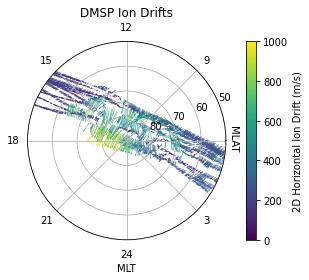

In [1]:
# Plot multiple orbital passes across polar cap.
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_rlim(0, 40.)
ax.set_xticks(np.linspace(0, 2. * np.pi - np.pi / 4., 8))
ax.set_xticklabels(['', 9, 12, 15, 18, 21, 24, 3])
ax.set_xlabel('MLT')
ax.set_yticks([10, 20, 30, 40])
ax.set_yticklabels([80, 70, 60, 50])
ax.text(np.deg2rad(-5.), 41, 'MLAT', rotation=-90.)
ax.grid(True)

# Location of spacecraft in relative polar coords for plotting.
theta = ivm['mlt'] * (np.pi / 12.) - np.pi / 2.
radius = 90. - np.abs(ivm['mlat'])

# Calculate magnitude of ion drifts for color values.
mag = np.sqrt(ivm['ion_vel_pc_x']**2 + ivm['ion_vel_pc_y']**2)

# Make plot of ion drifts.
slice_x = ma.masked_where(np.isnan(ivm['ion_vel_pc_x']), ivm['ion_vel_pc_x'])
slice_y = ma.masked_where(np.isnan(ivm['ion_vel_pc_y']), ivm['ion_vel_pc_y'])
vec_plot = ax.quiver(theta, radius, slice_x, slice_y, mag, scale=10000,
                    clim=[0, 1000.])

# Plot drifts without both an RPA and DM measurement in red.
ipartial, = np.where(ivm['partial'])
ax.quiver(theta[ipartial], radius[ipartial], slice_x[ipartial], slice_y[ipartial], color='r',
          scale=10000)

# Title, colorbar, and save.
plt.title('DMSP Ion Drifts')
label = ''.join(['(', ivm.meta['ion_vel_pc_x', ivm.meta.labels.units], ')'])
label = ''.join(['2D Horizontal Ion Drift ', label])
plt.colorbar(vec_plot, label=label)
plt.tight_layout()
plt.savefig('ex_dmsp_methods.png')